In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Lambda, Concatenate, Dropout
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Lambda, Concatenate

In [ ]:
# Define Hyperparameters:
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
learning_rate = 0.001
momentum = 0.9
alpha = 1.0

In [ ]:
#Defining the ShuffleNetV2 architecture
def shufflenet_v2(input_shape, num_classes):
    # Define the architecture

    # Input layer
    input_tensor = Input(shape=input_shape)

    # Stage 1
    x = Conv2D(24, (3, 3), strides=(2, 2), padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Stage 2
    x = shufflenet_unit(x, in_channels=24, out_channels=116, strides=2, stage=2, block=1)
    x = shufflenet_unit(x, in_channels=116, out_channels=116, strides=1, stage=2, block=2)
    x = shufflenet_unit(x, in_channels=116, out_channels=116, strides=1, stage=2, block=3)
    x = shufflenet_unit(x, in_channels=116, out_channels=116, strides=1, stage=2, block=4)

    # Stage 3
    x = shufflenet_unit(x, in_channels=116, out_channels=232, strides=2, stage=3, block=1)
    x = shufflenet_unit(x, in_channels=232, out_channels=232, strides=1, stage=3, block=2)
    x = shufflenet_unit(x, in_channels=232, out_channels=232, strides=1, stage=3, block=3)
    x = shufflenet_unit(x, in_channels=232, out_channels=232, strides=1, stage=3, block=4)
    x = shufflenet_unit(x, in_channels=232, out_channels=232, strides=1, stage=3, block=5)
    x = shufflenet_unit(x, in_channels=232, out_channels=232, strides=1, stage=3, block=6)

    # Stage 4
    x = shufflenet_unit(x, in_channels=232, out_channels=464, strides=2, stage=4, block=1)
    x = shufflenet_unit(x, in_channels=464, out_channels=464, strides=1, stage=4, block=2)
    x = shufflenet_unit(x, in_channels=464, out_channels=464, strides=1, stage=4, block=3)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer (Dense) with 128 neurons
    x = Dense(1280, activation='relu')(x)
    # Dropout layer
    x = Dropout(0.8)(x)

    # Fully Connected Layer (Dense)
    x = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=x, name='shufflenetv2')

    return model

def shufflenet_unit(x, in_channels, out_channels, strides, stage, block):
    if strides == 2:
        out_channels -= in_channels  # Adjust the number of output channels

    # First pointwise convolution
    x = Conv2D(out_channels // 2, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise convolution
    x = DepthwiseConv2D((3, 3), padding='same', strides=strides, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second pointwise convolution
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Skip connection
    if strides == 1 and in_channels == out_channels:
        x = Add()([x, x])  # Identity mapping
    elif strides == 2:
        avg_pool = Lambda(lambda y: tf.nn.avg_pool2d(y, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID'))(x)
        x = Concatenate()([avg_pool, avg_pool])  # Double the channels

    x = ReLU()(x)

    return x

model = shufflenet_v2(input_shape, num_classes)
model.summary()

Model: "shufflenetv2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 24)         648       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 24)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 24)         0         ['batch_normalizati

In [ ]:
# Define a function to load images and labels from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):  # Adjust file extension as needed
                img = cv2.imread(os.path.join(class_dir, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, input_shape[:2])  # Resize to the desired input shape
                label = class_names.index(class_name)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load train, validation, and test data
train_images, train_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/train')
validation_images, validation_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/val')
test_images, test_labels = load_data_from_directory('/content/drive/MyDrive/Training/Data/Data_file/test')

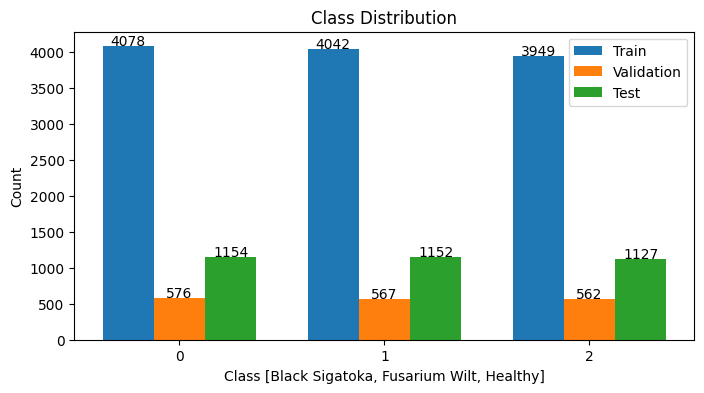

In [ ]:
#Counting and ploting the distribution of the classes
def plot_class_distribution(train_labels, validation_labels, test_labels):
    # Calculate class counts for each set
    train_class_counts = np.bincount(train_labels)
    validation_class_counts = np.bincount(validation_labels)
    test_class_counts = np.bincount(test_labels)

    # Get the number of unique classes
    num_classes = len(train_class_counts)

    # Generate class labels (class names)
    class_labels = [str(i) for i in range(num_classes)]

    # Create a bar chart to display class distribution
    x = np.arange(num_classes)  # x-axis values
    width = 0.25  # Width of bars

    plt.figure(figsize=(8, 4))
    plt.bar(x - width, train_class_counts, width, label='Train')
    plt.bar(x, validation_class_counts, width, label='Validation')
    plt.bar(x + width, test_class_counts, width, label='Test')

    plt.xlabel('Class [Black Sigatoka, Fusarium Wilt, Healthy]')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(x, class_labels)

    # Add labels above the bars
    for i in range(num_classes):
        plt.text(x[i] - width, train_class_counts[i] + 10, str(train_class_counts[i]), ha='center')
        plt.text(x[i], validation_class_counts[i] + 10, str(validation_class_counts[i]), ha='center')
        plt.text(x[i] + width, test_class_counts[i] + 10, str(test_class_counts[i]), ha='center')

    plt.legend()
    plt.show()
# Usage
plot_class_distribution(train_labels, validation_labels, test_labels)

In [ ]:
# One-hot encode the class labels
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
validation_labels_onehot = to_categorical(validation_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/train',  # Train set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/val',  # Validation set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Training/Data/Data_file/test',  # Test set
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12069 images belonging to 3 classes.
Found 1705 images belonging to 3 classes.
Found 3433 images belonging to 3 classes.


In [ ]:
# Create and compile the ShuffleNetV2 model
model = shufflenet_v2(input_shape=input_shape, num_classes=num_classes)

In [ ]:
# Create optimizer with custom parameters
optimizer = Adam(learning_rate=learning_rate, beta_1=momentum)
# Compile
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Define the early stopping and learning rate reduction callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [ ]:
# Train the model
import time
start_time = time.time()
epochs = 100
history = model.fit(train_images,train_labels_onehot,batch_size=batch_size,epochs=epochs,
                    validation_data=(validation_images, validation_labels_onehot), callbacks=[early_stopping]
)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100
378/378 [==============================] - 32s 48ms/step - loss: 0.1773 - accuracy: 0.9422 - val_loss: 0.2700 - val_accuracy: 0.9050
Epoch 2/100
378/378 [==============================] - 17s 46ms/step - loss: 0.1513 - accuracy: 0.9506 - val_loss: 0.4581 - val_accuracy: 0.8704
Epoch 3/100
378/378 [==============================] - 17s 45ms/step - loss: 0.1370 - accuracy: 0.9564 - val_loss: 0.1974 - val_accuracy: 0.9378
Epoch 4/100
378/378 [==============================] - 17s 46ms/step - loss: 0.1002 - accuracy: 0.9656 - val_loss: 0.0994 - val_accuracy: 0.9677
Epoch 5/100
378/378 [==============================] - 18s 46ms/step - loss: 0.0956 - accuracy: 0.9697 - val_loss: 0.1945 - val_accuracy: 0.9378
Epoch 6/100
378/378 [==============================] - 18s 46ms/step - loss: 0.0943 - accuracy: 0.9703 - val_loss: 0.1393 - val_accuracy: 0.9519
Epoch 7/100
378/378 [==============================] - 18s 47ms/step - loss: 0.0918 - accuracy: 0.9699 - val_loss: 0.1242 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

108/108 [==============================] - 2s 14ms/step - loss: 0.1119 - accuracy: 0.9639
Test Loss: 0.1119
Test Accuracy: 0.9639


In [ ]:
# Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

108/108 [==============================] - 2s 12ms/step


In [ ]:
# Generate classification report
class_labels = sorted(os.listdir('/content/drive/MyDrive/Training/Data/Data_file/test'))  # Get class names from the test directory
report = classification_report(test_labels, predicted_labels, target_names=class_labels)
print(report)

                precision    recall  f1-score   support

BLACK_SIGATOKA       0.97      0.96      0.96      1154
 FUSARIUM_WILT       0.94      0.96      0.95      1152
       HEALTHY       0.99      0.97      0.98      1127

      accuracy                           0.96      3433
     macro avg       0.96      0.96      0.96      3433
  weighted avg       0.96      0.96      0.96      3433



In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='weighted')
# Calculate recall
recall = recall_score(test_labels, predicted_labels, average='weighted')
# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9638799883483833
Precision: 0.9642851685923416
Recall: 0.9638799883483833
F1-score: 0.9639828279472442


108/108 [==============================] - 1s 12ms/step


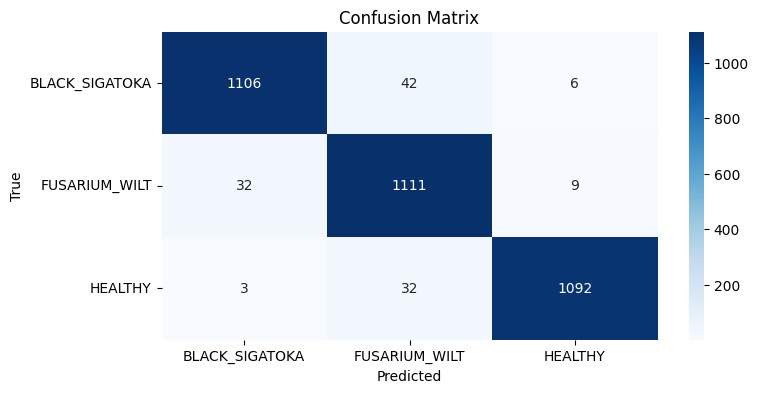

In [ ]:
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# Generate confusion matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
plt.title('Confusion Matrix')
plt.show()

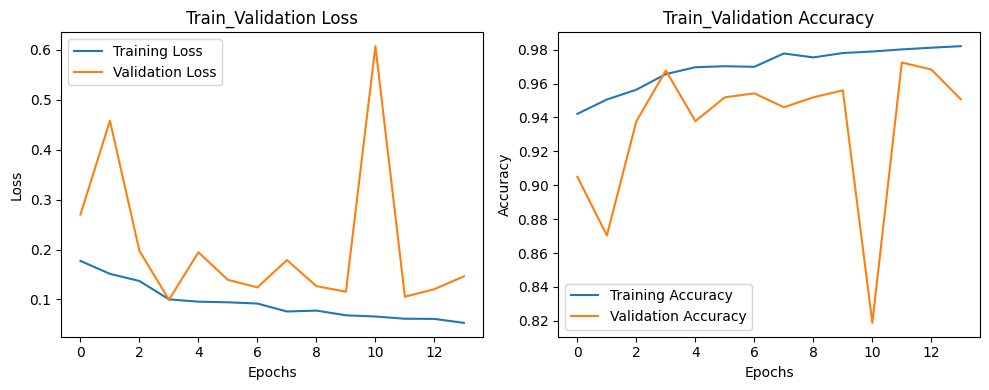

In [ ]:
#Plot loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train_Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Train_Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()